In [1]:
import pandas as pd
import ta
from binance.client import Client
import ccxt
import mplfinance as mpf
import numpy as np
from math import floor
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import config

client = Client(config.api_key, config.api_secret)
# Create Binance client instance
exchange = ccxt.binance({
    'apiKey': config.api_key,
    'secret': config.api_secret,
})

In [2]:
# barcha balanslarni korsatadi
# info = client.get_account()
# balans = info['balances']
# for x in balans:
#     if float(x['free']) > 0:
#         print(x)

In [3]:
balance = client.get_asset_balance(asset='USDT')
balance # USDT ga tegishgli balansni korsatadi

{'asset': 'USDT', 'free': '0.39314268', 'locked': '0.00000000'}

In [4]:
# Get latest bitcoin price
btc_price = client.get_symbol_ticker(symbol="BNBUSDT")

# Print the price
print("Bitcoin price: ", btc_price['price'])


Bitcoin price:  325.10000000


In [5]:
# Define symbol and interval
symbol = 'BNBUSDT'
interval = Client.KLINE_INTERVAL_1HOUR

# fetch 30 minute klines for the last month of 2017
klines = client.get_historical_klines(symbol, interval) #, "1 Yan, 2023", "1 Jan, 2025") # vergul qoyib tugash nuqtasini yosa ham boladi , "1 Jan, 2018")

# Convert klines to pandas dataframe
data = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

# Set timestamp as index
data.set_index('timestamp', inplace=True)

# Convert timestamp to datetime format
data.index = pd.to_datetime(data.index, unit='ms')
# data.close_time = pd.to_datetime(data.close_time, unit='ms')

# data type converse float
df = data[['open', 'high', 'low', 'close', 'volume']].astype(float)

df # oxirgi narx

,open,high,low,close,volume
timestamp,,,,,
2023-03-21 19:00:00,337.1,338.5,336.8,337.9,12936.696
2023-03-21 20:00:00,337.9,338.7,337.3,337.6,14482.148
2023-03-21 21:00:00,337.5,337.7,335.8,336.9,14766.959
2023-03-21 22:00:00,336.8,337.0,334.6,335.4,16588.378
2023-03-21 23:00:00,335.4,335.5,334.3,334.4,20396.436
...,...,...,...,...,...
2023-05-02 07:00:00,324.0,324.8,323.5,323.6,15773.135
2023-05-02 08:00:00,323.6,324.0,323.4,323.7,16587.853
2023-05-02 09:00:00,323.8,324.5,323.6,324.4,11786.631


In [6]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

bnb_macd = get_macd(df['close'], 26, 12, 9)
bnb_macd

,macd,signal,hist
timestamp,,,
2023-03-21 19:00:00,0.000000,0.000000,0.000000
2023-03-21 20:00:00,-0.023932,-0.004786,-0.019145
2023-03-21 21:00:00,-0.098249,-0.023479,-0.074770
2023-03-21 22:00:00,-0.275014,-0.073786,-0.201228
2023-03-21 23:00:00,-0.490142,-0.157057,-0.333085
...,...,...,...
2023-05-02 07:00:00,-1.930209,-1.359579,-0.570630
2023-05-02 08:00:00,-1.982734,-1.484210,-0.498524
2023-05-02 09:00:00,-1.945450,-1.576458,-0.368992


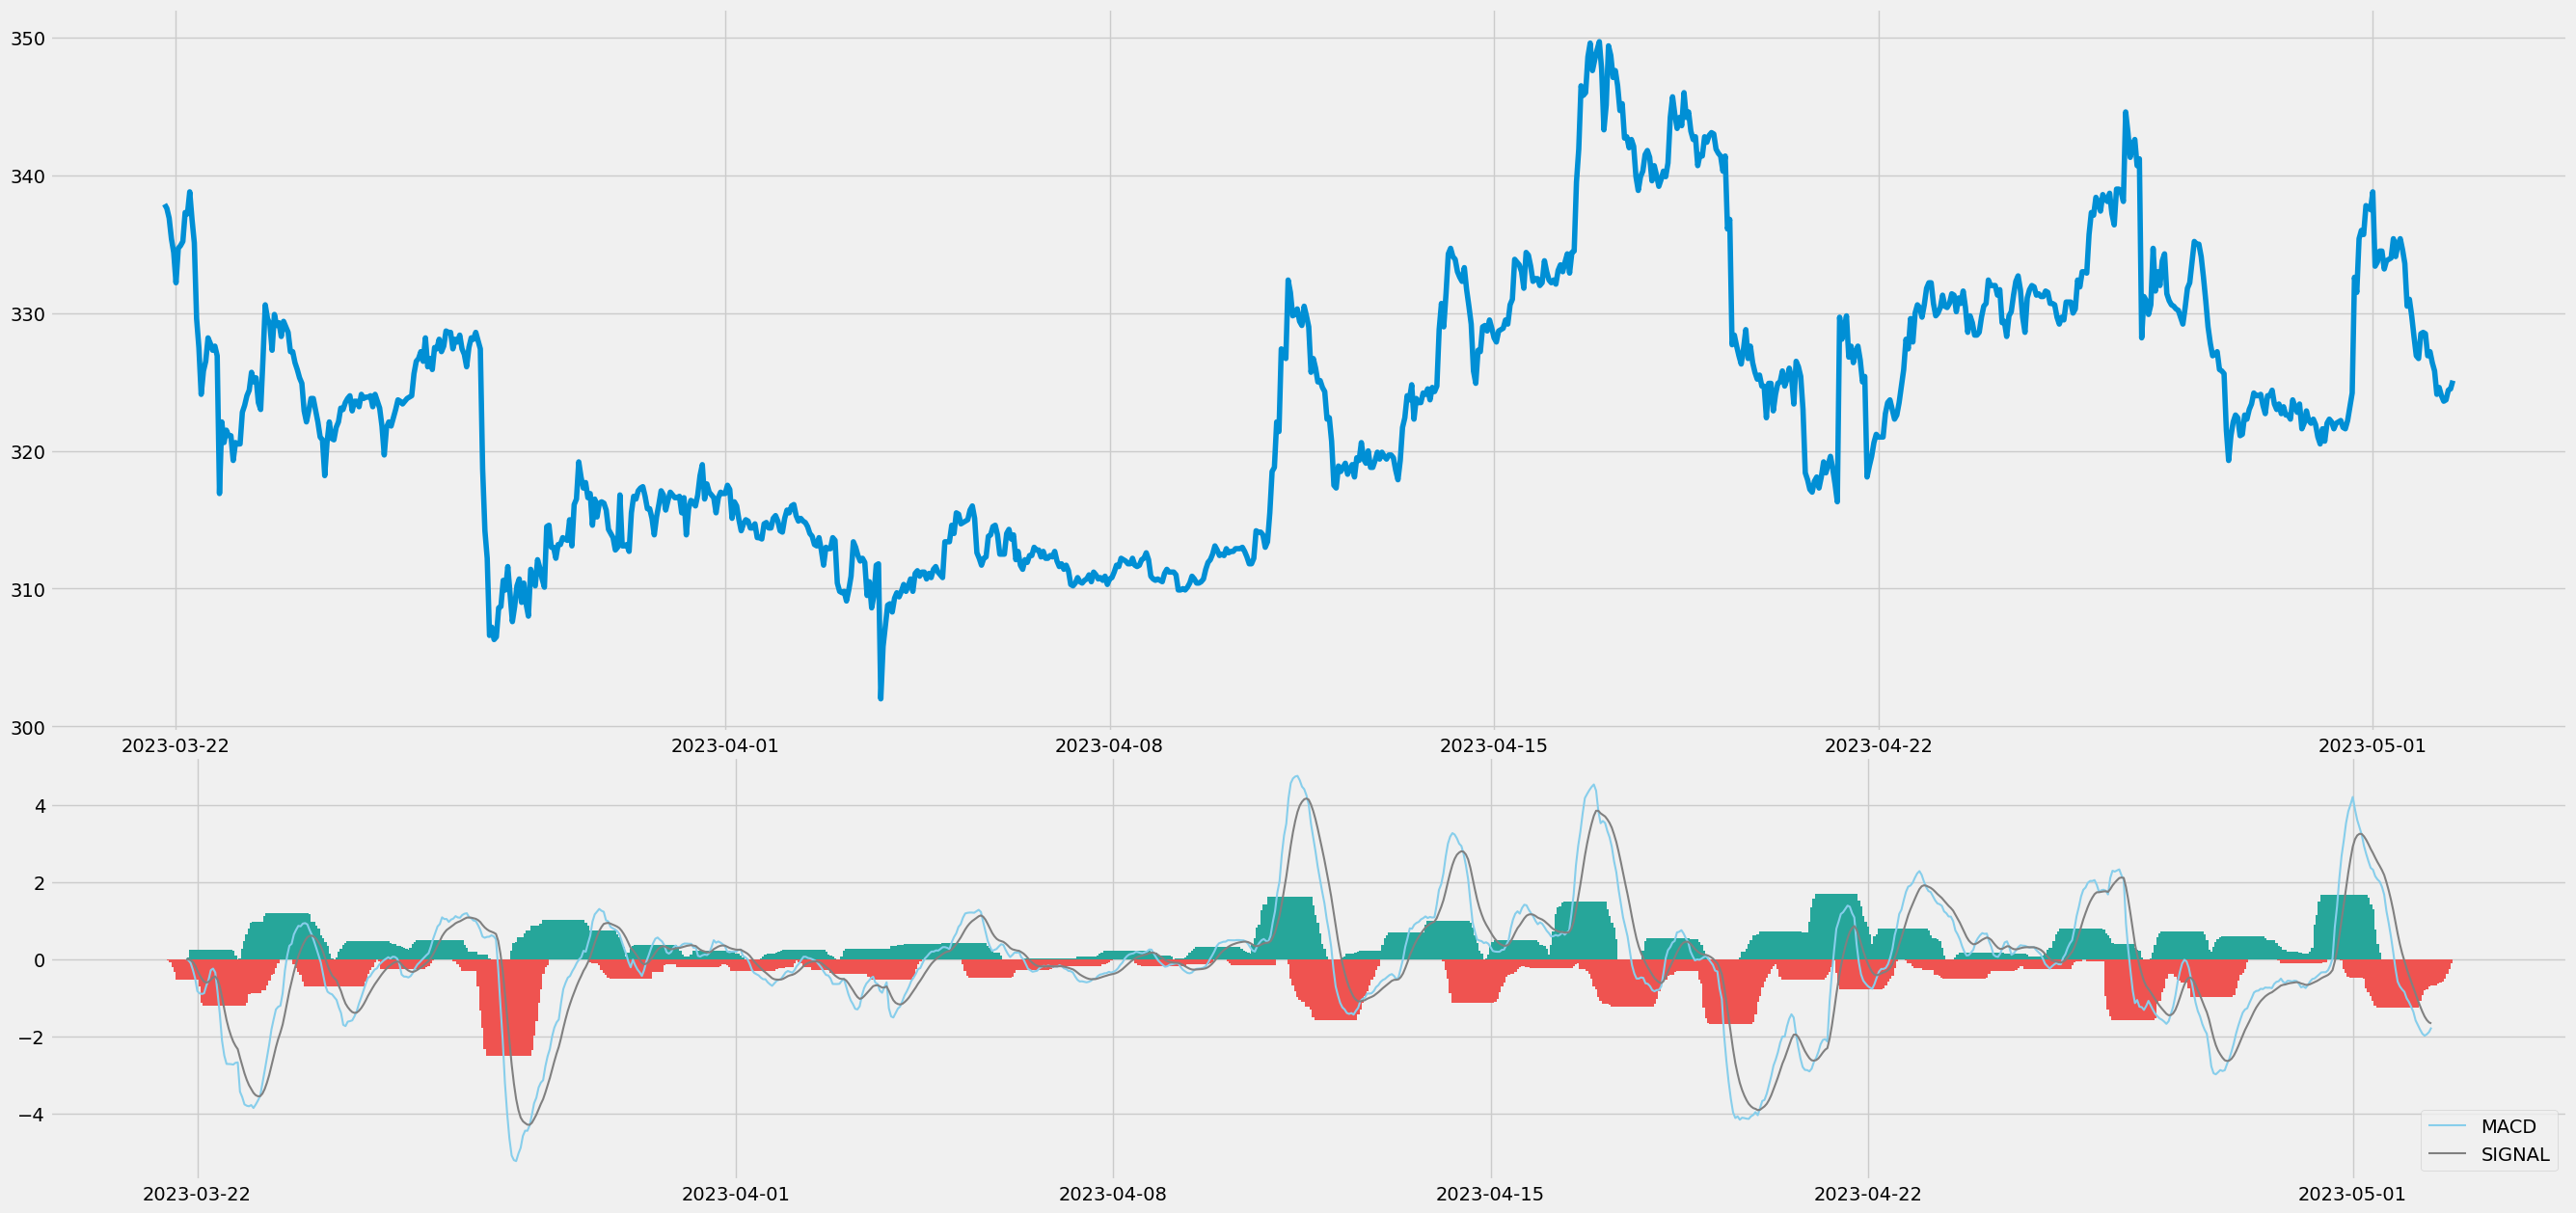

In [7]:
plt.rcParams['figure.figsize'] = (30, 15)
plt.style.use('fivethirtyeight')
def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'skyblue', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'grey', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(df['close'], bnb_macd['macd'], bnb_macd['signal'], bnb_macd['hist'])

In [8]:
def implement_macd_strategy(prices, data):
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)

    return buy_price, sell_price, macd_signal

buy_price, sell_price, macd_signal = implement_macd_strategy(df['close'], bnb_macd)

In [9]:
signals = pd.DataFrame( {"buy_price": buy_price, "sell_price": sell_price, "macd_signal": macd_signal} )
signals

,buy_price,sell_price,macd_signal
0,NaN,NaN,0
1,NaN,337.6,-1
2,NaN,NaN,0
3,NaN,NaN,0
4,NaN,NaN,0
...,...,...,...
995,NaN,NaN,0
996,NaN,NaN,0
997,NaN,NaN,0
998,NaN,NaN,0


In [60]:
df.to_csv("BNB_df.csv")
bnb_macd.to_csv("BNB_macd.csv")
signals.to_csv("Singanls.csv")

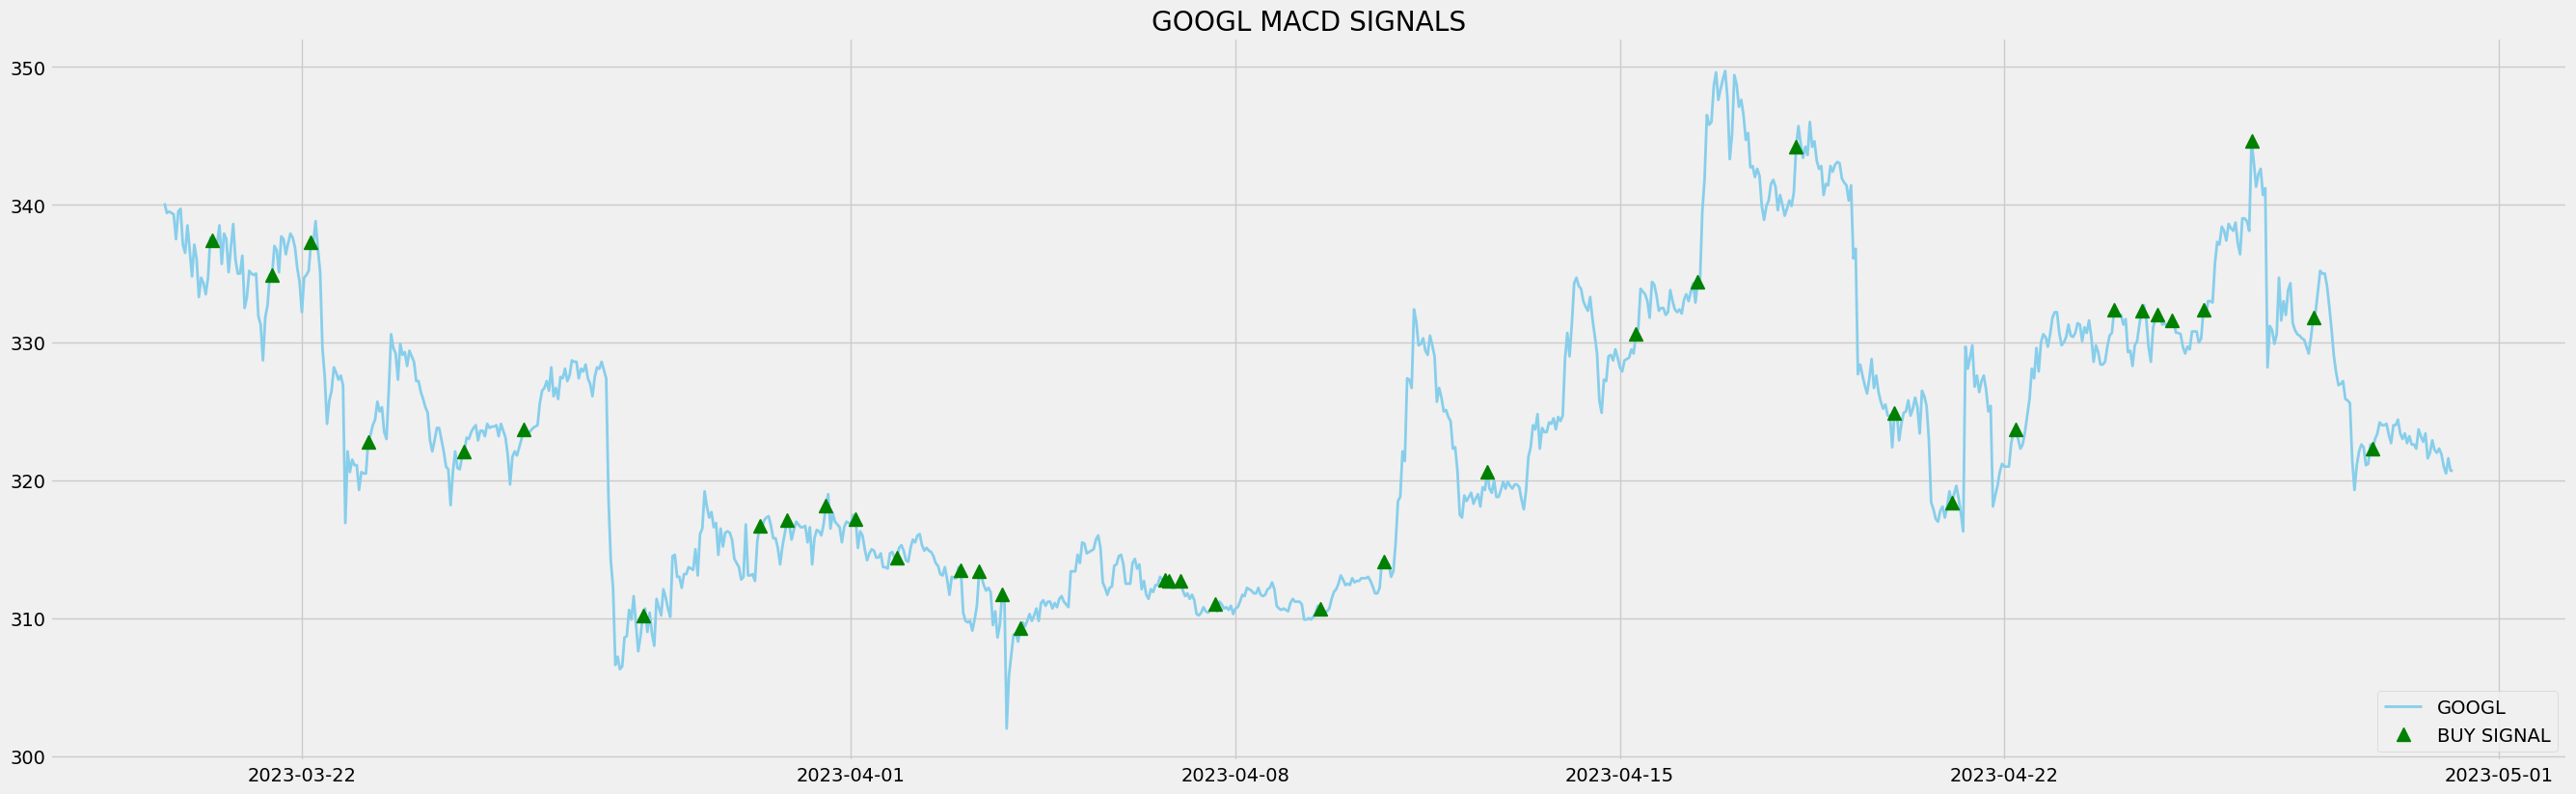

In [25]:
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
# ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(df['close'], color = 'skyblue', linewidth = 2, label = 'GOOGL')
ax1.plot(df.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
# ax1.plot(df.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('GOOGL MACD SIGNALS')
# ax2.plot(bnb_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
# ax2.plot(bnb_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')
#
# for i in range(len(bnb_macd)):
#     if str(bnb_macd['hist'][i])[0] == '-':
#         ax2.bar(bnb_macd.index[i], bnb_macd['hist'][i], color = '#ef5350')
#     else:
#         ax2.bar(bnb_macd.index[i], bnb_macd['hist'][i], color = '#26a69a')

plt.legend(loc = 'lower right')
plt.show()